In [273]:
import matplotlib.pyplot
from pyomo.environ import *
from util.util import get_root_dir
import pandas as pd
import numpy as np
from ordered_set import OrderedSet

In [274]:
proj_dir = get_root_dir() + "/superstructure/"
# data_dir = proj_dir + "plastic_case/"

In [275]:
df = pd.read_csv("data/productive.csv", index_col=0)
df;

In [276]:
productive_links = []
for index, row in df.iterrows():
    for column in df.columns:
        if row[column] == 1:
            productive_links.append((index, column))

productive_links

[('R1A-OL', 'FL1A'),
 ('R2A-OL', 'FL1A'),
 ('R3A-OL', 'FL1A'),
 ('R1C-OL', 'FL1A'),
 ('R2C-OL', 'FL1A'),
 ('R3C-OL', 'FL1A'),
 ('R4C-OL', 'FL1A'),
 ('DT1A-OL', 'PROD-ELEC'),
 ('DT2A-OL', 'PROD-ELEC'),
 ('DT2A-OL', 'PROD-GAS'),
 ('DT2A-OL', 'PROD-JTF'),
 ('DT3A-OL', 'PROD-ELEC'),
 ('DT3A-OL', 'PROD-JTF'),
 ('DT3A-OL', 'PROD-DSL'),
 ('FL1A-OL', 'DT1A'),
 ('FEED-LDPE', 'R1A'),
 ('FEED-LDPE', 'R1C'),
 ('FEED-LDPE', 'R2C'),
 ('FEED-LDPE', 'R3C'),
 ('FEED-HDPE', 'R2A'),
 ('FEED-HDPE', 'R1C'),
 ('FEED-HDPE', 'R2C'),
 ('FEED-HDPE', 'R3C'),
 ('FEED-PP', 'R3A'),
 ('FEED-PP', 'R2C'),
 ('FEED-PP', 'R3C'),
 ('FEED-PP', 'R4C'),
 ('FEED-H2', 'R1A'),
 ('FEED-H2', 'R2A'),
 ('FEED-H2', 'R3A'),
 ('R1A-OH', 'PROD-WASTE'),
 ('R2A-OH', 'PROD-WASTE'),
 ('R3A-OH', 'PROD-WASTE'),
 ('R1C-OH', 'PROD-WASTE'),
 ('R2C-OH', 'PROD-WASTE'),
 ('R3C-OH', 'PROD-WASTE'),
 ('R4C-OH', 'PROD-WASTE'),
 ('DT1A-OH', 'DT2A'),
 ('DT1A-OH', 'PROD-ELEC'),
 ('DT1A-OH', 'PROD-GAS'),
 ('DT1A-OH', 'PROD-JTF'),
 ('DT2A-OH', 'DT3A'),
 ('

In [277]:
conversions = {}
conversions["R1A"] = {}
conversions["R2A"] = {}
conversions["R3A"] = {}
conversions["R1C"] = {}
conversions["R2C"] = {}
conversions["R3C"] = {}
conversions["R4C"] = {}
df_R1A = pd.read_excel("data/reaction_data.xlsx", sheet_name="R1A", header=0)
df_R2A = pd.read_excel("data/reaction_data.xlsx", sheet_name="R2A", header=0)
df_R3A = pd.read_excel("data/reaction_data.xlsx", sheet_name="R3A", header=0)
df_R1C = pd.read_excel("data/reaction_data.xlsx", sheet_name="R1C", header=0)
df_R2C = pd.read_excel("data/reaction_data.xlsx", sheet_name="R2C", header=0)
df_R3C = pd.read_excel("data/reaction_data.xlsx", sheet_name="R3C", header=0)
df_R4C = pd.read_excel("data/reaction_data.xlsx", sheet_name="R4C", header=0)

for index, row in df_R1A.iterrows():
    if not row["Code"] in {"Waste", "WASTE", "waste"}:
        conversions["R1A"][row["Code"]] = row["Yield"]

for index, row in df_R2A.iterrows():
    if not row["Code"] in {"Waste", "WASTE", "waste"}:
        conversions["R2A"][row["Code"]] = row["Yield"]

for index, row in df_R3A.iterrows():
    if not row["Code"] in {"Waste", "WASTE", "waste"}:
        conversions["R3A"][row["Code"]] = row["Yield"]

for index, row in df_R1C.iterrows():
    if not row["Code"] in {"Waste", "WASTE", "waste"}:
        conversions["R1C"][row["Code"]] = row["Yield"]

for index, row in df_R2C.iterrows():
    if not row["Code"] in {"Waste", "WASTE", "waste"}:
        conversions["R2C"][row["Code"]] = row["Yield"]

for index, row in df_R3C.iterrows():
    if not row["Code"] in {"Waste", "WASTE", "waste"}:
        conversions["R3C"][row["Code"]] = row["Yield"]

for index, row in df_R4C.iterrows():
    if not row["Code"] in {"Waste", "WASTE", "waste"}:
        conversions["R4C"][row["Code"]] = row["Yield"]

conversions;

In [278]:
properties = pd.read_csv("filled_properties.csv", index_col=0)
properties;

In [279]:
def prepare_sets():
    res = {}
    elements = pd.read_csv("data/elements_case1.csv", index_col=0)
    res["i"] = elements.index.tolist()

    compounds = [f'C{n}A' for n in range(1, 23)] + ['H2', 'LDPE', 'HDPE', 'PP', 'WASTE'] +  [f'C{n}E' for n in range(2, 21)]
    res["k"] =  compounds

    return res

In [280]:
res = prepare_sets()
res["i"];

In [281]:
def build_model(m, data):
    # =================================== Sets ===================================
    m.i = Set(initialize=data["i"])
    m.itech = Set(within=m.i, initialize=["R1A", "R2A", "R3A", "R1C","R2C", "R3C", "R4C",
                                          "DT1A", "DT2A", "DT3A", "FL1A"])

    m.isource = Set(within=m.i, initialize=["FEED-LDPE", "FEED-HDPE", "FEED-PP", "FEED-H2", "R1A", "R2A", "R3A", "R1C","R2C", "R3C", "R4C",
                                            "DT1A", "DT2A", "DT3A", "FL1A"])
    m.isink = Set(within=m.i, initialize=["R1A-OL", "R2A-OL", "R3A-OL", "R1C-OL", "R2C-OL", "R3C-OL", "R4C-OL",
                                          "DT1A-OL", "DT2A-OL", "DT3A-OL", "FL1A-OL",
                                          "R1A-OH", "R2A-OH", "R3A-OH", "R1C-OH", "R2C-OH", "R3C-OH", "R4C-OH",
                                          "DT1A-OH", "DT2A-OH", "DT3A-OH", "FL1A-OH",
                                          "PROD-WASTE","PROD-ELEC","PROD-GAS","PROD-JTF","PROD-DSL", "PROD-WAX"])

    irxn = ["R1A", "R2A", "R3A", "R1C","R2C", "R3C", "R4C"]
    isep = ["DT1A", "DT2A", "DT3A"]
    ifil = ["FL1A"]

    m.irxn = Set(within=m.itech, initialize=irxn)
    m.isep = Set(within=m.itech, initialize=isep)
    m.ifil = Set(within=m.itech, initialize=ifil)

    irxnL = ["R1A-OL", "R2A-OL", "R3A-OL", "R1C-OL", "R2C-OL", "R3C-OL", "R4C-OL"]
    isepL = ["DT1A-OL", "DT2A-OL", "DT3A-OL"]
    ifilL = ["FL1A-OL"]

    irxnH = ["R1A-OH", "R2A-OH", "R3A-OH", "R1C-OH", "R2C-OH", "R3C-OH", "R4C-OH"]
    isepH = ["DT1A-OH", "DT2A-OH", "DT3A-OH"]
    ifilH = ["FL1A-OH"]

    m.itechL = Set(within=m.i, initialize=irxnL+isepL+ifilL)
    m.itechH = Set(within=m.i, initialize=irxnH+isepH+ifilH)
    m.itech_out = Set(within=m.i, initialize=irxnL+isepL+ifilL+irxnH+isepH+ifilH)

    m.irxnL = Set(within=m.i, initialize=irxnL)
    m.isepL = Set(within=m.i, initialize=isepL)
    m.ifilL = Set(within=m.i, initialize=ifilL)
    m.irxnH = Set(within=m.i, initialize=irxnH)
    m.isepH = Set(within=m.i, initialize=isepH)
    m.ifilH = Set(within=m.i, initialize=ifilH)

    m.ifeed = Set(within=m.i, initialize=["FEED-LDPE", "FEED-HDPE", "FEED-PP", "FEED-H2"])
    m.iprod = Set(within=m.i, initialize=["PROD-WASTE", "PROD-ELEC","PROD-GAS","PROD-JTF","PROD-DSL", "PROD-WAX"])
    m.ifuel = Set(within=m.iprod, initialize=["PROD-GAS","PROD-JTF","PROD-DSL"])
    m.iwax = Set(within=m.iprod, initialize=["PROD-WAX"])
    m.ielec = Set(within=m.iprod, initialize=["PROD-ELEC"])

    m.k = Set(initialize=data["k"])
    m.kfeed = Set(within=m.k, initialize=["LDPE","HDPE","PP","H2"])
    m.kplastic = Set(within=m.kfeed, initialize=["LDPE","HDPE","PP"])
    kfuel = [key for key, value in properties["trace"].to_dict().items() if value == 0]
    m.kfuel = Set(within=m.k, initialize=kfuel)
    kegen = [key for key, value in properties["egen"].to_dict().items() if value == 1]
    m.kegen = Set(within=m.k, initialize = kegen)

    m.kolefins = Set(within=m.k, initialize=[f'C{n}E' for n in range(2, 21)])

    def is_waste(k):
        return k in {"WASTE", "waste",  "Waste"}

    m.is_waste = is_waste

    m.productive_links = Set(dimen=2, within=m.i * m.i, initialize = productive_links)
    m.p = Set(initialize=range(1,7), doc="realization of distillation technologies")
    # =================================== beginning of port matching ===================================
    port_match = {}
    for item in irxnL + isepL + ifilL + irxnH + isepH + ifilH:
        base, suffix = item.rsplit('-', 1)
        match_suffix = 'OH' if suffix == 'OL' else 'OL'
        port_match[item] = f"{base}-{match_suffix}"

    heavy_match = {}
    # Map -OH to no suffix
    for item in irxnH + isepH + ifilH:
        base, _ = item.rsplit('-', 1)
        heavy_match[item] = f"{base}"
    # Map no suffix to -OH
    for item in irxn + isep + ifil:
        heavy_match[item] = f"{item}-OH"

    light_match = {}
    # Map -OL to no suffix
    for item in irxnL + isepL + ifilL:
        base, _ = item.rsplit('-', 1)
        light_match[item] = base
    # Map no suffix to OL
    for item in irxn + isep + ifil:
        light_match[item] = f"{item}-OL"

    m.port_match = port_match # match xxx-OL  and xxx-OH: that is, m.port_match[xxx-OL] gives xxx-OH and vice versa
    m.heavy_match = heavy_match # match xxx  and xxx-OH: that is, m.port_match[xxx-OH] gives xxx and vice versa
    m.light_match = light_match # match xxx  and xxx-OL: that is, m.port_match[xxx-OL] gives xxx and vice versa

    # =================================== end of port matching ===================================

    m.inlets = {} # the elements going into the i
    m.outlets = {} # the elements going out of the i

    for i in m.i:
        m.inlets[i] = OrderedSet()
        m.outlets[i] = OrderedSet()

    for (a,b) in productive_links:
        m.inlets[b].append(a)
        m.outlets[a].append(b)

    # =================================== finding inlets and outlets ===================================

    m.rxn_ref = {}
    m.rxn_ref["R1A"] = "LDPE"
    m.rxn_ref["R2A"] = "HDPE"
    m.rxn_ref["R3A"] = "PP"
    m.rxn_ref["R4C"] = "PP"

    m.rxn_species = {}
    hdc_list = [f'C{n}A' for n in range(1, 20)]
    hdc_list.append("H2")

    pyr_list = [f'C{n}A' for n in range(1, 23)] + [f'C{n}E' for n in range(2, 21)] + ['H2']

    r1a_list = [i for i in hdc_list]
    r1a_list.append("LDPE")
    m.rxn_species["R1A"] =  OrderedSet(r1a_list)

    r2a_list = [i for i in hdc_list]
    r2a_list.append("HDPE")
    m.rxn_species["R2A"] =  OrderedSet(r2a_list)

    r3a_list = [i for i in hdc_list]
    r3a_list.append("PP")
    m.rxn_species["R3A"] = OrderedSet(r3a_list)

    m.rxn_species["R1C"] = OrderedSet(pyr_list + ["PP"])
    m.rxn_species["R2C"] = OrderedSet(pyr_list + ["PP", "LDPE", "HDPE"])
    m.rxn_species["R3C"] = OrderedSet(pyr_list + ["PP", "LDPE", "HDPE"])
    m.rxn_species["R4C"] = OrderedSet(pyr_list + ["LDPE", "HDPE"])

    m.conversions = conversions

    # =================================== Params ===================================
    # big M
    m.M = Param(initialize=1e14)

    m.fload = Param(m.kfeed, initialize={"LDPE": 20000, "HDPE":80000, "PP":96000})
    m.dist_scale = Var(m.isep, initialize=100, doc="scale of surrogate used for separation units")

    m.MW = Param(m.k, initialize=properties["MW"].to_dict())

    m.LHV = Param(m.kegen, initialize={kp : properties["LHV"].to_dict()[kp] for kp in m.kegen})
    m.rho = Param(m.kfuel, initialize={kp : properties["rho"].to_dict()[kp] for kp in m.kfuel})
    m.mu = Param(m.kfuel, initialize={kp :properties["mu"].to_dict()[kp] for kp in m.kfuel})
    m.TB = Param(m.k, initialize=properties["TB"].to_dict())
    m.bpLo = Param(m.ifuel, initialize={"PROD-GAS": 5, "PROD-JTF": 5, "PROD-DSL": 5} )
    m.bpUp = Param(m.ifuel, initialize={"PROD-GAS": 98,"PROD-JTF": 98.5,"PROD-DSL": 95} )
    m.olefinLim = Param(m.ifuel, initialize={"PROD-GAS": 18,"PROD-JTF": 2,"PROD-DSL": 20} )

    m.sepCut = Param(m.isep, initialize={"DT1A": np.ceil(m.TB["C4A"]), "DT2A": np.ceil(m.TB["C8A"]), "DT3A": np.ceil(m.TB["C12A"])})
    # m.sepCut = Param(m.isep, initialize={"DT1A": np.ceil(m.TB["C4A"]), "DT2A": np.ceil(m.TB["C12A"]), "DT3A": np.ceil(m.TB["C12A"])})
    # C4/C5; C8/C9; C12/C13; C16/C17

    m.mat_price = Param(m.ifeed, initialize={"FEED-LDPE": 330, "FEED-HDPE": 330, "FEED-PP": 330, "FEED-H2":2100}, doc="$/per tonne")
    m.fuel_price = Param(m.ifuel, initialize={"PROD-GAS": 1180,"PROD-JTF": 310,"PROD-DSL":1050}, doc="$/per tonne")
    m.wax_price = Param(m.iwax, initialize={"PROD-WAX": 1420})
    # m.wax_price = Param(m.iwax, initialize={}, doc="$/per tonne")
    m.electric_price = Param(initialize=2.221e-8, doc="/J")
    m.elec_eff = Param(initialize=0.4, doc="conversion efficiency %")

    # economics
    # ["R1A", "R2A", "R3A", "DT1A", "DT2A", "DT3A", "DT4A"]
    m.alpha = Param(initialize=0.6, doc="scale-up factor")
    m.beta_AL = Param(initialize=0.1165, doc="annualized factor")
    m.beta_CC = Param(m.itech, initialize={"R1A": 16021577, "R2A": 33152563, "R3A":37557152,
                                           "R1C": 3661402,  "R2C": 3827926,  "R3C":3904240,  "R4C":4022879,
                                           "DT1A": 0, "DT2A": 0, "DT3A": 0,
                                           "FL1A": 0})

    m.beta_OCVR = Param(m.irxn, initialize={"R1A": 208268,  "R2A": 608680,  "R3A":650589,
                                            "R1C": 153535,  "R2C": 124401,  "R3C":124214, "R4C":409989})

    m.beta_OCFR = Param(m.irxn, initialize={"R1A": 1327761, "R2A": 1342950, "R3A":1344780,
                                            "R1C": 730214,  "R2C": 732831,  "R3C":734588, "R4C":1073239})

    m.beta_OCVS = Param(m.isep, initialize={"DT1A": 0, "DT2A": 0, "DT3A": 0})
    m.beta_OCFS = Param(m.isep, initialize={"DT1A": 0, "DT2A": 0, "DT3A": 0})

    m.FBasis =  Param(m.itech, initialize={"R1A": 2500 * 8,  "R2A": 10000 * 8, "R3A": 12000 * 8,
                                           "R1C": 10000 * 8, "R2C": 10000 * 8, "R3C": 10000 * 8, "R4C": 10000 * 8,
                                           "DT1A": 8000 * 8, "DT2A": 5000 * 8, "DT3A": 2000 * 8,
                                           "FL1A": 5000 * 8
                                           })

    # =================================== Vars ===================================
    # binary: if a technology is selected
    m.y = Var(m.itech, domain=Binary)
    # m.z = Var(m.isep, domain=Binary)

    # split fraction
    eta_index = []
    for (i, ip) in m.productive_links:
        if len(m.outlets[i]) > 1 and i in m.itech_out:
            eta_index.append((i, ip))
    eta_index = OrderedSet(eta_index)
    m.eta_index = Set(within=m.productive_links, initialize=eta_index)

    m.eta = Var(m.eta_index, domain=Binary)
    # m.eta.setlb(0)
    # m.eta.setub(1)

    # flow rates
    m.F = Var(m.productive_links, m.k,domain=NonNegativeReals)
    m.FRefT = Var(m.irxn, domain=NonNegativeReals)
    m.FI = Var(m.itech, m.k, domain=NonNegativeReals)
    m.FP = Var(m.irxn, m.k, domain=NonNegativeReals)
    m.FOL = Var(m.itechL, m.k, domain=NonNegativeReals)
    m.FOH = Var(m.itechH, m.k, domain=NonNegativeReals)
    m.FT = Var(m.itech, domain=NonNegativeReals)
    m.Fcap = Var(m.itech, domain=NonNegativeReals)

    # surrogate-related for separation
    m.reflux = Var(m.isep, domain=NonNegativeReals)

    # cost and sales
    m.annual_cost = Var(domain=Reals)
    m.capex = Var(domain=NonNegativeReals)
    m.opex = Var(domain=NonNegativeReals)
    m.cc = Var(m.itech, domain=NonNegativeReals)
    m.oc = Var(m.itech, domain=NonNegativeReals)
    m.feedCost = Var(m.ifeed, domain=NonNegativeReals)
    m.fuel_rev = Var(m.ifuel, domain=NonNegativeReals)
    m.wax_rev = Var(m.iwax, domain=NonNegativeReals)
    m.elec_rev = Var(m.ielec, domain=NonNegativeReals)


In [282]:
def build_feed_cons(m):
    # Load constriants for feed
    def eq_fd1(m ,kfeed):
        if kfeed == "LDPE":
            return  sum(m.F["FEED-LDPE",i, kfeed] for i in m.outlets["FEED-LDPE"]) == m.fload[kfeed]
        elif kfeed == "HDPE":
            return  sum(m.F["FEED-HDPE",i, kfeed] for i in m.outlets["FEED-HDPE"]) == m.fload[kfeed]
        elif kfeed == "PP":
            return  sum(m.F["FEED-PP",i, kfeed] for i in m.outlets["FEED-PP"]) == m.fload[kfeed]
        return Constraint.Skip
    m.eq_fd1 = Constraint(m.kfeed, rule=eq_fd1)

    # pure feed only
    # def eq_fd2(m, kfeed):
    #     if kfeed == "LDPE":
    #         return  sum(m.F["FEED-LDPE","R1A",k] + m.F["FEED-LDPE","R1C",k] + m.F["FEED-LDPE","R2C",k] +  m.F["FEED-LDPE","R3C",k] for k in m.k if k != "LDPE") == 0
    #     elif kfeed == "HDPE":
    #         return  sum(m.F["FEED-HDPE","R2A",k] + m.F["FEED-HDPE","R1C",k] + m.F["FEED-HDPE","R2C",k] +  m.F["FEED-HDPE","R3C",k] for k in m.k if k != "HDPE") == 0
    #     elif kfeed == "PP":
    #         return  sum(m.F["FEED-PP","R3A",k] + + m.F["FEED-PP","R2C",k] + m.F["FEED-PP","R3C",k] +  m.F["FEED-PP","R4C",k]  for k in m.k if k != "PP") == 0
    #     elif kfeed == "H2":
    #         return  sum(m.F["FEED-H2","R1A",k] + m.F["FEED-H2","R2A",k] + m.F["FEED-H2","R3A",k] for k in m.k if k != "H2" ) == 0
    #     return Constraint.Skip
    # m.eq_fd2 = Constraint(m.kfeed, rule=eq_fd2)

    for (i, ip, k) in m.F.index_set():
        if i == "FEED-LDPE" and k != "LDPE":
            m.F[i,ip,k].fix(0)
        elif i == "FEED-HDPE" and k != "HDPE":
            m.F[i,ip,k].fix(0)
        elif i == "FEED-PP" and k != "PP":
            m.F[i,ip,k].fix(0)
        elif i == "FEED-H2" and k != "H2":
            m.F[i,ip,k].fix(0)

    return


In [283]:
def build_tech(m):

    def Eq_T1(m, itech, k):
        return m.FI[itech, k] == sum(m.F[ip, itech, k] for ip in m.inlets[itech])
    m.Eq_T1 = Constraint(m.itech, m.k, rule=Eq_T1)
    # Check this

    # def Eq_T2(m, itechL, k):
    #     return m.FOL[itechL, k] == sum(m.F[itechL, ip, k] for ip in m.outlets[itechL])
    # m.Eq_T2 = Constraint(m.itechL, m.k, rule=Eq_T2)
    #
    # def Eq_T3(m, itechH, k):
    #     return m.FOH[itechH, k] == sum(m.F[itechH, ip, k] for ip in m.outlets[itechH])
    # m.Eq_T3 = Constraint(m.itechH, m.k, rule=Eq_T3)

    def Eq_T2(m, itechL, ip, k):
        if not ip in m.outlets[itechL]:
            return Constraint.Skip
        if len(m.outlets[itechL]) < 2:
            return m.FOL[itechL, k] == m.F[itechL, ip, k]
        # return m.eta[itechL, ip] * m.FOL[itechL, k] == m.F[itechL, ip, k]
        return m.eta[itechL, ip] * m.M >= m.F[itechL, ip, k]
    m.Eq_T2 = Constraint(m.itechL, m.i, m.k, rule=Eq_T2)

    def Eq_T3(m, itechH, ip, k):
        if not ip in m.outlets[itechH]:
            return Constraint.Skip
        if len(m.outlets[itechH]) < 2:
            return m.FOH[itechH, k] == m.F[itechH, ip, k]
        # return m.eta[itechH, ip] * m.FOH[itechH, k] == m.F[itechH, ip, k]
        return m.eta[itechH, ip] * m.M >= m.F[itechH, ip, k]
    m.Eq_T3 = Constraint(m.itechH, m.i, m.k, rule=Eq_T3)

    def Eq_T4(m, itech_out):
        if len(m.outlets[itech_out]) > 1:
            # if itech_out in m.itechL:
            #     return m.y[m.light_match[itech_out]] == sum(m.eta[itech_out, ip] for ip in m.outlets[itech_out])
            # return m.y[m.heavy_match[itech_out]] == sum(m.eta[itech_out, ip] for ip in m.outlets[itech_out])
            return 1 == sum(m.eta[itech_out, ip] for ip in m.outlets[itech_out])
        return Constraint.Skip
    m.Eq_T4 = Constraint(m.itech_out, rule=Eq_T4)

    def Eq_T4a(m, itechL, k):
        if len(m.outlets[itechL]) > 1:
            return m.FOL[itechL, k] == sum(m.F[itechL, ip, k] for ip in m.outlets[itechL])
        return Constraint.Skip
    m.Eq_T4a = Constraint(m.itechL, m.k, rule=Eq_T4a)

    def Eq_T4b(m, itechH, k):
        if len(m.outlets[itechH]) > 1:
            return m.FOH[itechH, k] == sum(m.F[itechH, ip, k] for ip in m.outlets[itechH])
        return Constraint.Skip
    m.Eq_T4b = Constraint(m.itechH, m.k, rule=Eq_T4b)

    def Eq_T5(m, itech):
        return m.FT[itech] == sum(m.FI[itech, k] for k in m.k)
    m.Eq_T5 = Constraint(m.itech, rule=Eq_T5)

    def Eq_T6(m, itech):
        return m.Fcap[itech] <= m.M * m.y[itech]
    m.Eq_T6 = Constraint(m.itech, rule=Eq_T6)

    def Eq_T7(m, itech):
        return m.FT[itech] <= m.Fcap[itech]
    m.Eq_T7 = Constraint(m.itech, rule=Eq_T7)

    return

In [284]:
def build_rxn(m):
    # find the basis of yield
    def Eq_R1(m, irxn):
        # pure reactant
        if irxn in m.rxn_ref.keys():
            kref = m.rxn_ref[irxn]
            return m.FRefT[irxn] == m.FI[irxn, kref]
        # mixture reactant
        elif irxn == "R1C":
            return m.FRefT[irxn] == m.FI[irxn, "LDPE"] + m.FI[irxn, "HDPE"]
        elif irxn in {"R2C", "R3C"}:
            return m.FRefT[irxn] == m.FI[irxn, "LDPE"] + m.FI[irxn, "HDPE"] + m.FI[irxn, "PP"]
        raise IndexError
    m.Eq_R1 = Constraint(m.irxn, rule=Eq_R1)

    # conversion
    def Eq_R2aI(m, irxn, k):
        # reactant
        if k in m.kplastic:
            # pure reactant
            if irxn in m.rxn_ref.keys():
                # full conversion
                if k == m.rxn_ref[irxn]:
                    return m.FP[irxn,k] == 0
                #  the rest stays the same
                else:
                    return m.FI[irxn, k] == m.FP[irxn,k]
            else:
               if irxn == "R1C":
                   if k in {"LDPE", "HDPE"}:
                       return m.FP[irxn,k] == 0
                   else:
                       return m.FI[irxn, k] == m.FP[irxn,k]
               elif irxn in {"R2C", "R3C"}:
                   if k in {"LDPE", "HDPE", "PP"}:
                       return m.FP[irxn,k] == 0
                   else:
                       return m.FI[irxn, k] == m.FP[irxn,k]
               else:
                   raise IndexError("Unimplemented reaction")
        return Constraint.Skip
    m.Eq_R2aI = Constraint(m.irxn, m.k, rule=Eq_R2aI)

    def Eq_R2aII(m, irxn, k):
        if (not k in m.kplastic) and (k in m.rxn_species[irxn]):
            return m.FI[irxn, k] + m.conversions[irxn][k] * m.FRefT[irxn] >= m.FP[irxn,k]
        return Constraint.Skip
    m.Eq_R2aII = Constraint(m.irxn, m.k, rule=Eq_R2aII)

    # other species
    def Eq_R2b(m, irxn, k):
        if (not k in m.kplastic) and (not k in m.rxn_species[irxn]) and (not m.is_waste(k)):
            return m.FI[irxn, k] == m.FP[irxn,k]
        return Constraint.Skip
    m.Eq_R2b = Constraint(m.irxn, m.k, rule=Eq_R2b)

    # waste
    def Eq_R2c(m, irxn, k):
        if m.is_waste(k):
            return m.FP[irxn,k] == sum(m.FI[irxn,kpp] for kpp in m.k) - sum(m.FP[irxn,kp] for kp in m.k if not m.is_waste(kp))
        return Constraint.Skip
    m.Eq_R2c = Constraint(m.irxn, m.k, rule=Eq_R2c)

    # waste and only waste goes to waste stream
    def Eq_R3(m, irxn, k):
        if not m.is_waste(k):
            return m.FP[irxn, k] == m.FOL[m.light_match[irxn], k]
        return 0 == m.FOL[m.light_match[irxn], k]
    m.Eq_R3 = Constraint(m.irxn, m.k, rule=Eq_R3)

    # outgoing port balance
    def Eq_R4(m, irxn, k):
        if m.is_waste(k):
            return m.FP[irxn, k] == m.FOH[m.heavy_match[irxn], k]
        return 0 == m.FOH[m.heavy_match[irxn], k]
    m.Eq_R4 = Constraint(m.irxn, m.k, rule=Eq_R4)

    # saturation constriant for HDC
    def Eq_R_HDC1(m, irxn):
        if irxn in {"R1A", "R2A", "R3A"}:
            return m.FI[irxn,"H2"] >= 2 * m.FP[irxn, "H2"]
        return Constraint.Skip
    m.Eq_R_HDC1 = Constraint(m.irxn, rule=Eq_R_HDC1)

    # saturation constriant for HDC
    def Eq_R_pyro(m, irxn):
        if irxn in {"R2C", "R3C"}:
            if irxn == "R2C":
                return m.FI[irxn,"LDPE"] + m.FI[irxn,"HDPE"] == (6/4) * m.FI[irxn,"PP"]
            elif irxn == "R3C":
                return m.FI[irxn,"LDPE"] + m.FI[irxn,"HDPE"] == (4/6) * m.FI[irxn,"PP"]
        return Constraint.Skip
    m.Eq_R_pyro = Constraint(m.irxn, rule=Eq_R_pyro)

    return

In [285]:
def build_separation(m):
    # Surrogate-based models
    # Sharp binary separation

    def Eq_filL(m, k):
        if m.TB[k] <= np.ceil(m.TB["C20A"]):
            return m.FI["FL1A", k] == m.FOL[m.light_match["FL1A"], k]
        return 0 == m.FOL[m.light_match["FL1A"], k]
    m.eq_fil1 = Constraint(m.k, rule=Eq_filL)

    def Eq_filH(m, k):
        if m.TB[k] > np.ceil(m.TB["C20A"]):
            return m.FI["FL1A", k] == m.FOH[m.heavy_match["FL1A"], k]
        return 0 == m.FOH[m.heavy_match["FL1A"], k]
    m.eq_fil2 = Constraint(m.k, rule=Eq_filH)

    def eq_sep1(m, isep, k):
        if m.TB[k] <= m.sepCut[isep]:
            return m.FI[isep, k] == m.FOL[m.light_match[isep], k]
        return 0 == m.FOL[m.light_match[isep], k]
    m.eq_sep1 = Constraint(m.isep, m.k, rule=eq_sep1)

    def eq_sep2(m, isep, k):
        if m.TB[k] > m.sepCut[isep]:
            return m.FI[isep, k] == m.FOH[m.heavy_match[isep], k]
        return 0 == m.FOH[m.heavy_match[isep], k]
    m.eq_sep2 = Constraint(m.isep, m.k, rule=eq_sep2)

    return

In [286]:
def blending(m):
    # blending constraints
    # based on boiling points
    def trace_lim(m, ifuel):
        return sum(sum(m.F[ip, ifuel, k]/m.MW[k] for k in m.k if not k in m.kfuel and not m.is_waste(k)) for ip in m.inlets[ifuel]) <= \
               0.01 * sum(sum(m.F[ip, ifuel, k]/m.MW[k] for k in m.k if not m.is_waste(k)) for ip in m.inlets[ifuel])
    m.trace_lim = Constraint(m.ifuel, rule=trace_lim)

    def olefin_lim(m, ifuel):
        return sum(sum(m.F[ip, ifuel, k]/m.MW[k] for k in m.k if k in m.kolefins and not m.is_waste(k)) for ip in m.inlets[ifuel]) <= \
               m.olefinLim[ifuel]/100 * sum(sum(m.F[ip, ifuel, k]/m.MW[k] for k in m.k if not m.is_waste(k)) for ip in m.inlets[ifuel])
    m.olefin_lim = Constraint(m.ifuel, rule=olefin_lim)

    def _BPlo(m, ifuel):
        if ifuel == "PROD-GAS":
            return sum(sum(m.F[ip, ifuel, k]/m.MW[k] for k in m.k if m.TB[k] <= 30 and not m.is_waste(k)) for ip in m.inlets[ifuel]) <= \
                   m.bpLo[ifuel]/100 * sum(sum(m.F[ip, ifuel, k]/m.MW[k] for k in m.k if not m.is_waste(k)) for ip in m.inlets[ifuel])
        elif ifuel == "PROD-JTF":
            return sum(sum(m.F[ip, ifuel, k]/m.MW[k] for k in m.k if m.TB[k] <= 160 and not m.is_waste(k)) for ip in m.inlets[ifuel]) <= \
                   m.bpLo[ifuel]/100 * sum(sum(m.F[ip, ifuel, k]/m.MW[k] for k in m.k if not m.is_waste(k)) for ip in m.inlets[ifuel])
        elif ifuel == "PROD-DSL":
            return sum(sum(m.F[ip, ifuel, k]/m.MW[k] for k in m.k if m.TB[k] <= 150 and not m.is_waste(k)) for ip in m.inlets[ifuel]) <= \
                   m.bpLo[ifuel]/100  * sum(sum(m.F[ip, ifuel, k]/m.MW[k] for k in m.k if not m.is_waste(k)) for ip in m.inlets[ifuel])
            # return sum(sum(m.F[ip, ifuel, k]/m.MW[k] for k in m.k if m.TB[k] <= 210 and not m.is_waste(k)) for ip in m.inlets[ifuel]) <= \
            #            m.bpLo[ifuel]/100  * sum(sum(m.F[ip, ifuel, k]/m.MW[k] for k in m.k if not m.is_waste(k)) for ip in m.inlets[ifuel])
        return Constraint.Skip
    m.fuel_bplo = Constraint(m.ifuel, rule=_BPlo)

    def _BPup(m, ifuel):
        if ifuel == "PROD-GAS":
            return sum(sum(m.F[ip, ifuel, k]/m.MW[k] for k in m.k if m.TB[k] <= 215 and not m.is_waste(k)) for ip in m.inlets[ifuel]) >= \
                   m.bpUp[ifuel]/100 * sum(sum(m.F[ip, ifuel, k]/m.MW[k] for k in m.k if not m.is_waste(k)) for ip in m.inlets[ifuel])
        elif ifuel == "PROD-JTF":
            return sum(sum(m.F[ip, ifuel, k]/m.MW[k] for k in m.k if m.TB[k] <= 300 and not m.is_waste(k)) for ip in m.inlets[ifuel]) >= \
                   m.bpUp[ifuel]/100 * sum(sum(m.F[ip, ifuel, k]/m.MW[k] for k in m.k if not m.is_waste(k)) for ip in m.inlets[ifuel])
        elif ifuel == "PROD-DSL":
            return sum(sum(m.F[ip, ifuel, k]/m.MW[k] for k in m.k if m.TB[k] <= 360 and not m.is_waste(k)) for ip in m.inlets[ifuel]) >= \
                   m.bpUp[ifuel]/100 * sum(sum(m.F[ip, ifuel, k]/m.MW[k] for k in m.k if not m.is_waste(k)) for ip in m.inlets[ifuel])
        return Constraint.Skip
    m.fuel_bpup = Constraint(m.ifuel, rule=_BPup)

    return

In [287]:
def economics(m):
    # economics
    def Eq_E1(m):
        return m.capex + m.opex - sum(m.fuel_rev[ifuel] for ifuel in m.ifuel) - sum(m.elec_rev[ielec] for ielec in m.ielec) - sum(m.wax_rev[iwax] for iwax in m.iwax) == m.annual_cost
    m.Eq_E1 = Constraint(rule=Eq_E1, doc="Eq-E1: annualized cost")

    def Eq_E2(m, ifeed):
        return m.feedCost[ifeed] == m.mat_price[ifeed] * sum(sum(m.F[ifeed,i, k] for k in m.k) for i in m.outlets[ifeed])
    m.Eq_E2 = Constraint(m.ifeed, rule=Eq_E2, doc="Eq-E2: feed cost")

    def Eq_E3(m, ielec):
        return m.elec_rev[ielec] == m.electric_price * m.elec_eff * sum(sum(m.LHV[kegen] * m.F[i,ielec, kegen]*1e-3/m.MW[kegen] for kegen in m.kegen) for i in m.inlets[ielec])
    m.Eq_E3 = Constraint(m.ielec, rule=Eq_E3, doc="Eq-E3: energy generation revenue")

    def Eq_E4a(m, ifuel):
        return m.fuel_rev[ifuel] == m.fuel_price[ifuel] * sum(sum(m.F[i, ifuel, k] for k in m.k) for i in m.inlets[ifuel])
    m.Eq_E4a = Constraint(m.ifuel, rule=Eq_E4a, doc="Eq-E4: revenue for fuel products")

    def Eq_E4b(m, iwax):
        return m.wax_rev[iwax] == m.wax_price[iwax] * sum(sum(m.F[i, iwax, k] for k in m.k) for i in m.inlets[iwax])
    m.Eq_E4b = Constraint(m.iwax, rule=Eq_E4b, doc="Eq-E4: revenue for wax products")

    def Eq_E6(m):
        return m.beta_AL * sum(m.cc[itech] for itech in m.itech) == m.capex
    m.Eq_E6 = Constraint(rule=Eq_E6, doc="Eq-E6: CAPEX")

    def Eq_E7(m):
        return sum(m.feedCost[ifeed] for ifeed in m.ifeed) + sum(m.oc[itech] for itech in m.itech) == m.opex
    m.Eq_E7 = Constraint(rule=Eq_E7, doc="Eq-E7: OPEX")

    def Eq_E8(m, itech):
        # return m.beta_CC[itech] * (m.Fcap[itech] / m.FBasis[itech]) ** m.alpha == m.cc[itech]
        return m.beta_CC[itech] * (m.Fcap[itech] / m.FBasis[itech]) == m.cc[itech]
    m.Eq_E8 = Constraint(m.itech, rule=Eq_E8, doc="Eq-E8: capital_cost")

    def Eq_E9(m, irxn):
        return m.beta_OCVR[irxn] * (m.Fcap[irxn] / m.FBasis[irxn]) + m.beta_OCFR[irxn] * m.y[irxn] == m.oc[irxn]
    m.Eq_E9 = Constraint(m.irxn, rule=Eq_E9, doc="Eq-E9: operating_cost_rxn")

    def Eq_E10(m, isep):
        # place holder: set to 0
        return 0 == m.oc[isep]
    m.Eq_E10 = Constraint(m.isep, rule=Eq_E10, doc="Eq-E10: operating_cost_sep")



In [288]:
m1 = ConcreteModel()
build_model(m1, res)

In [289]:
# m1.eta.pprint()
# m1.Eq_T3.pprint()

In [290]:
build_feed_cons(m1)
build_tech(m1)
build_rxn(m1)
build_separation(m1)
blending(m1)
economics(m1)

In [291]:
def solve_model(m):
    m.obj = Objective(expr=m.annual_cost, sense=minimize)

    m.annual_cost.setub(1e12)
    m.annual_cost.setlb(-1e12)

    # def cdebug(m, ifuel):
    #     return sum(sum(m.F[i, ifuel, k] for k in m.k) for i in m.inlets[ifuel]) <= 9000000
    # m.cd = Constraint(m.ifuel, rule=cdebug)

    #opt2 = SolverFactory('gurobi_persistent')
    opt1 = SolverFactory('gams')
    io_options = dict()

    io_options['solver'] = "cplex"
    res = opt1.solve(m,
        tee=True,
        keepfiles=True,
        add_options = ['option reslim=7200; option optcr=0.0; option limrow=5000'],
        tmpdir=proj_dir+"/case_study/output",
        io_options=io_options)

    return res

In [292]:
# for i in m1.itech:
#     if not i in m1.irxn:
#         m1.y[i].fix(1)

In [293]:
# m1.y["R1A"].fix(0)
# m1.y["R2A"].fix(0)
# m1.y["R3A"].fix(0)

# m1.y["R1C"].fix(0)
# m1.y["R2C"].fix(0)
# m1.y["R3C"].fix(0)
# m1.y["R4C"].fix(0)

solve_model(m1)

--- Job model.gms Start 12/12/23 22:50:42 43.2.0 859d62d5 WEX-WEI x86 64bit/MS Windows
--- Applying:
    C:\GAMS\43\gmsprmNT.txt
    C:\Users\justi\OneDrive\Documents\GAMS\gamsconfig.yaml
--- GAMS Parameters defined
    Input D:\Optimization-Notebook\superstructure\case_study\output\model.gms
    Output D:\Optimization-Notebook\superstructure\case_study\output\output.lst
    ScrDir D:\Optimization-Notebook\superstructure\case_study\output\225j\
    SysDir C:\GAMS\43\
    CurDir D:\Optimization-Notebook\superstructure\case_study\output\
    LogOption 3
Licensee: Small MUD - 5 User License                     G221121|0002AP-GEN
          University of Delaware, Chemical and Biomolecular EngineeriDC3967
          C:\GAMS\43\gamslice.txt
          License Admin: Marianthi Ierapetritou, mgi@udel.edu              
Processor information: 1 socket(s), 10 core(s), and 20 thread(s) available
GAMS 43.2.0   Copyright (C) 1987-2023 GAMS Development. All rights reserved
--- Starting compilation
--- 

{'Problem': [{'Name': 'D:\\Optimization-Notebook/superstructure//case_study/output\\model.gms', 'Lower bound': -150534346.3724653, 'Upper bound': -150534346.3724653, 'Number of objectives': 1, 'Number of constraints': 3779.0, 'Number of variables': 3558.0, 'Number of binary variables': None, 'Number of integer variables': 29.0, 'Number of continuous variables': 3529.0, 'Number of nonzeros': 11764.0, 'Sense': 'minimize'}], 'Solver': [{'Name': 'GAMS (43, 2, 0, 0)', 'Status': 'ok', 'Return code': 0, 'Message': None, 'User time': 0.279999990016222, 'System time': None, 'Wallclock time': None, 'Termination condition': 'optimal', 'Termination message': None}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [294]:
res =  {iprod: value(sum(sum(m1.F[i, iprod, k] for k in m1.k) for i in m1.inlets[iprod])) for iprod in m1.iprod }
res

{'PROD-WASTE': 24627.210074032737,
 'PROD-ELEC': 8389.094082302327,
 'PROD-GAS': 43749.44249811406,
 'PROD-JTF': 0.0,
 'PROD-DSL': 0.0,
 'PROD-WAX': 119880.08932866479}

In [295]:
tmp = {}
for irxn in m1.irxn:
    for k in m1.k:
        if (not k in m1.kplastic) and (k in m1.rxn_species[irxn]):
                tmp[(irxn, k)]  = value(m1.FI[irxn, k] + m1.conversions[irxn][k] * m1.FRefT[irxn])
tmp
m1.kfuel.pprint()

kfuel : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :      k :   38 : {'C3A', 'C4A', 'C5A', 'C6A', 'C7A', 'C8A', 'C9A', 'C10A', 'C11A', 'C12A', 'C13A', 'C14A', 'C15A', 'C16A', 'C17A', 'C18A', 'C19A', 'C20A', 'C21A', 'C2E', 'C3E', 'C4E', 'C5E', 'C6E', 'C7E', 'C8E', 'C9E', 'C10E', 'C11E', 'C12E', 'C13E', 'C14E', 'C15E', 'C16E', 'C17E', 'C18E', 'C19E', 'C20E'}


<BarContainer object of 6 artists>

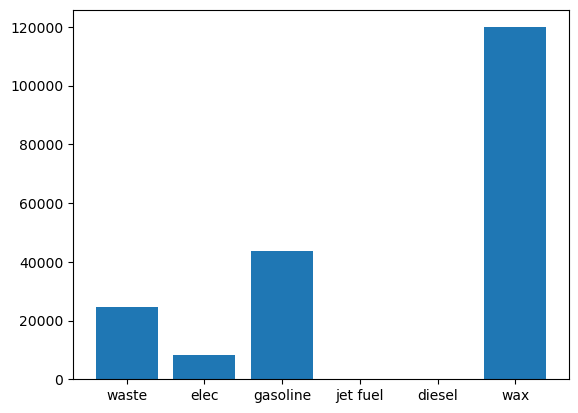

In [296]:
import matplotlib.pyplot as plt
plt.bar(["waste", "elec", "gasoline", "jet fuel", "diesel", "wax"], list(res.values()))

In [297]:
m1.TB.pprint()

TB : Size=46, Index=k, Domain=Any, Default=None, Mutable=False
    Key   : Value
     C10A : 174.155
     C10E :   170.6
     C11A : 195.928
     C11E :  192.67
     C12A : 216.323
     C12E :   213.0
     C13A : 235.466
     C13E :  232.84
     C14A : 253.577
     C14E :   251.1
     C15A : 270.685
     C15E :  268.46
     C16A : 286.864
     C16E :  284.87
     C17A :  302.15
     C17E :  300.33
     C18A :  316.71
     C18E :  314.82
     C19A :   329.9
     C19E :  329.02
      C1A : -161.49
     C20A :  343.78
     C20E :  342.39
     C21A :   356.5
     C22A :   368.6
      C2A :   -88.6
      C2E : -103.74
      C3A :  -42.04
      C3E :   -47.7
      C4A :    -0.5
      C4E :   -6.24
      C5A :   36.07
      C5E :   30.07
      C6A :   68.73
      C6E :   63.48
      C7A :   98.43
      C7E :   93.64
      C8A :  125.68
      C8E :  121.26
      C9A :  150.82
      C9E : 146.868
       H2 : -252.76
     HDPE :   68.75
     LDPE :   68.75
       PP :   68.75
    WASTE :     nan

<BarContainer object of 4 artists>

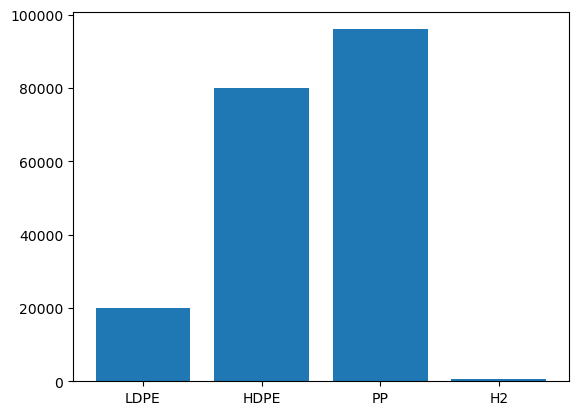

In [298]:
feedstock =  {ifeed: value(sum(sum(m1.F[ifeed, i, k] for k in m1.k) for i in m1.outlets[ifeed])) for ifeed in m1.ifeed}
feedstock
import matplotlib.pyplot as plt
plt.bar(["LDPE", "HDPE", "PP", "H2"], list(feedstock.values()))

<BarContainer object of 7 artists>

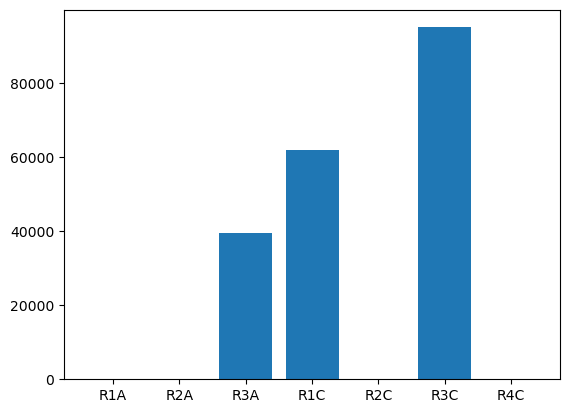

In [299]:

rxns =  {irxn: value(sum(m1.FI[irxn, k] for k in m1.k)) for irxn in m1.irxn}
rxns
import matplotlib.pyplot as plt
plt.bar(OrderedSet(m1.irxn), list(rxns.values()))

In [300]:
def summarize(m):
    # summarize the model for plotting
    res = {}

    annualized_capital = {}
    capital = {}
    operating = {}

    for itech in m.itech:
        annualized_capital[itech] = value(m.beta_AL * m.cc[itech])
        capital[itech] = value(m.cc[itech])
        operating[itech] = value(m.oc[itech])

    feedcost = {}
    for ifeed in m.ifeed:
        feedcost[ifeed] = value(m.feedCost[ifeed])

    prodrev = {}
    for i in m.ifuel:
        prodrev[i] = value(m.fuel_rev[i])
    for i in m.ielec:
        prodrev[i] = value(m.elec_rev[i])
    for i in m.iwax:
        prodrev[i] = value(m.wax_rev[i])

    fuel_comp = {}
    for i in m.ifuel:
        fuel_comp[i] = {}
        for k in m.kfuel:
            fuel_comp[i][k] = value(sum(m.F[ip, i, k] for ip in m.inlets[i]))

    prod_quantity = {}
    for i in m.ifuel:
        prod_quantity[i] = value(sum(sum(m.F[ip, i, k] for k in m.k) for ip in m.inlets[i]))
    for i in m.ielec:
        prod_quantity[i] = value(sum(sum(m.F[ip, i, k] for k in m.k) for ip in m.inlets[i]))
    for i in m.iwax:
        prod_quantity[i] = value(sum(sum(m.F[ip, i, k] for k in m.k) for ip in m.inlets[i]))

    res["annualized_capital"] = annualized_capital
    res["capital"] = capital
    res["operating"] = operating
    res["feed"] = feedcost
    res["product_revenue"] = prodrev
    res["fuel_comp"] = fuel_comp
    res["prod_quantity"] = prod_quantity

    return res

In [301]:
summary = summarize(m1)
summary

{'annualized_capital': {'R1A': 0.0,
  'R2A': 0.0,
  'R3A': 1802551.0432870456,
  'R1C': 330236.14689992514,
  'R2C': 0.0,
  'R3C': 541040.7385390464,
  'R4C': 0.0,
  'DT1A': 0.0,
  'DT2A': 0.0,
  'DT3A': 0.0,
  'FL1A': 0.0},
 'capital': {'R1A': 0.0,
  'R2A': 0.0,
  'R3A': 15472541.144094812,
  'R1C': 2834645.0377675975,
  'R2C': 0.0,
  'R3C': 4644126.511064775,
  'R4C': 0.0,
  'DT1A': 0.0,
  'DT2A': 0.0,
  'DT3A': 0.0,
  'FL1A': 0.0},
 'operating': {'R1A': 0.0,
  'R2A': 0.0,
  'R3A': 1612805.250434205,
  'R1C': 849080.2774187723,
  'R2C': 0.0,
  'R3C': 147753.60458747816,
  'R4C': 0.0,
  'DT1A': 0.0,
  'DT2A': 0.0,
  'DT3A': 0.0,
  'FL1A': 0.0},
 'feed': {'FEED-LDPE': 6600000.0,
  'FEED-HDPE': 26400000.0,
  'FEED-PP': 31680000.0,
  'FEED-H2': 1356255.564539136},
 'product_revenue': {'PROD-GAS': 51624342.14777459,
  'PROD-JTF': 0.0,
  'PROD-DSL': 0.0,
  'PROD-ELEC': 0.003692260573834,
  'PROD-WAX': 170229726.846704},
 'fuel_comp': {'PROD-GAS': {'C3A': 0.0,
   'C4A': 0.0,
   'C5A': 4171.

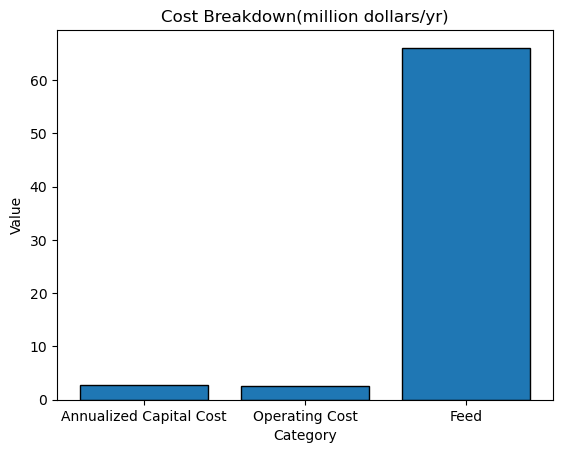

In [302]:
categories = ['Annualized Capital Cost', "Operating Cost", "Feed"]
# items: "annualized_capital", "operating cost", "feed cost"
values = np.array([sum(summary["annualized_capital"].values()), sum(summary["operating"].values()), sum(summary["feed"].values())])

# Create a bar chart
plt.bar(categories, values/1e6, edgecolor='black')

# Add labels and title
plt.ylabel("Value")
plt.xlabel("Category")
plt.title("Cost Breakdown(million dollars/yr)")
total_cost = sum(values);

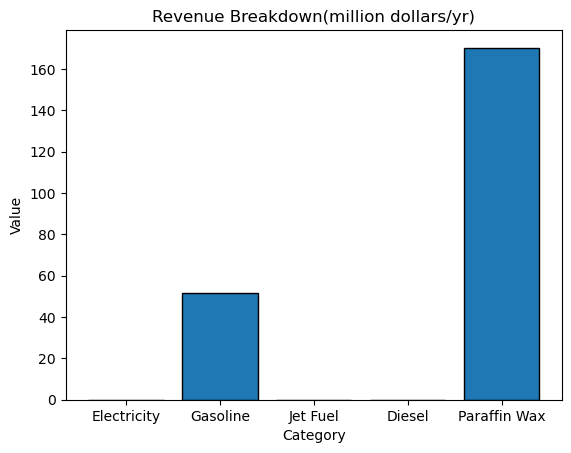

In [303]:
categories = ['Electricity', "Gasoline", "Jet Fuel", "Diesel", "Paraffin Wax"]
# items: "electricity", "gasoline", "jet fuel", "diesel", "wax"
values = np.array([summary["product_revenue"]["PROD-ELEC"], summary["product_revenue"]["PROD-GAS"], summary["product_revenue"]["PROD-JTF"], summary["product_revenue"]["PROD-DSL"], summary["product_revenue"]["PROD-WAX"]])

# Create a bar chart
plt.bar(categories, values/1e6, edgecolor='black')

# Add labels and title
plt.ylabel("Value")
plt.xlabel("Category")
plt.title("Revenue Breakdown(million dollars/yr)")
total_profit = sum(values);

In [304]:
(total_profit - total_cost)/1e6

150.53434637246525

Text(0.5, 1.0, 'Product Quantity')

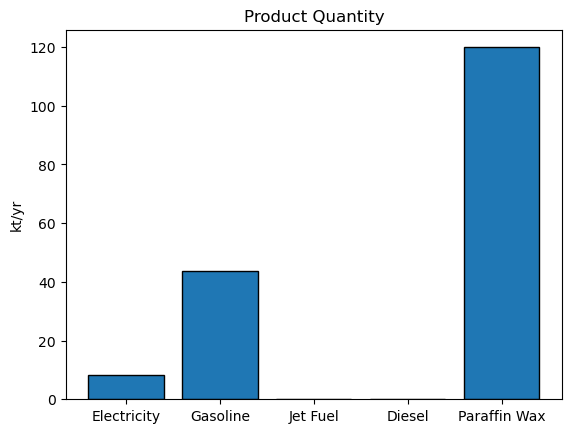

In [305]:
categories = ['Electricity', "Gasoline", "Jet Fuel", "Diesel", "Paraffin Wax"]
# items: "electricity", "gasoline", "jet fuel", "diesel", "wax"
values = np.array([summary["prod_quantity"]["PROD-ELEC"], summary["prod_quantity"]["PROD-GAS"], summary["prod_quantity"]["PROD-JTF"], summary["prod_quantity"]["PROD-DSL"], summary["prod_quantity"]["PROD-WAX"]])

# Create a bar chart
plt.bar(categories, values/1e3, edgecolor='black')

# Add labels and title
plt.ylabel("kt/yr")
plt.xlabel("")
plt.title("Product Quantity")

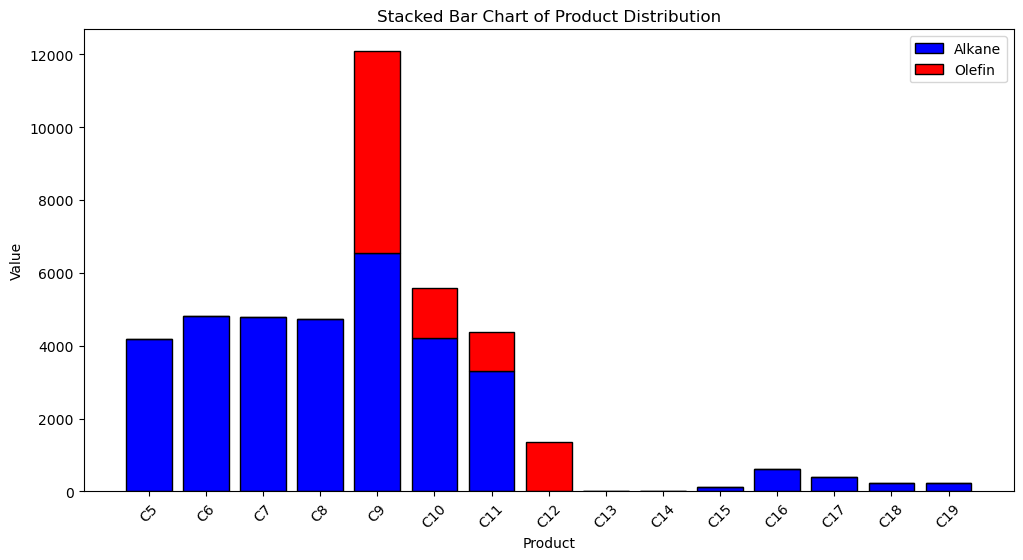

In [306]:
gas_data = summary["fuel_comp"]["PROD-GAS"]

# Separate data into two groups
groupA = [gas_data[key] for key in gas_data if key.endswith('A') and int(key[1:-1])>4 and int(key[1:-1])<20]
groupE = [gas_data[key] for key in gas_data if key.endswith('E') and int(key[1:-1])>4 and int(key[1:-1])<20]

# The position of the bars on the x-axis
r = range(len(groupA))

# Plotting the bars
plt.figure(figsize=(12, 6))
plt.bar(r, groupA, color='blue', edgecolor='black', label='Alkane')
plt.bar(r, groupE, bottom=groupA, color='red', edgecolor='black', label='Olefin')

# Add labels and title
plt.xticks(r, [key.replace('A', '') for key in gas_data if key.endswith('A') and int(key[1:-1])>4  and int(key[1:-1])<20], rotation=45)
plt.ylabel("Value")
plt.xlabel("Product")
plt.title("Stacked Bar Chart of Product Distribution")

# Create legend & Show graphic
plt.legend()
plt.show()
groupA, groupE;

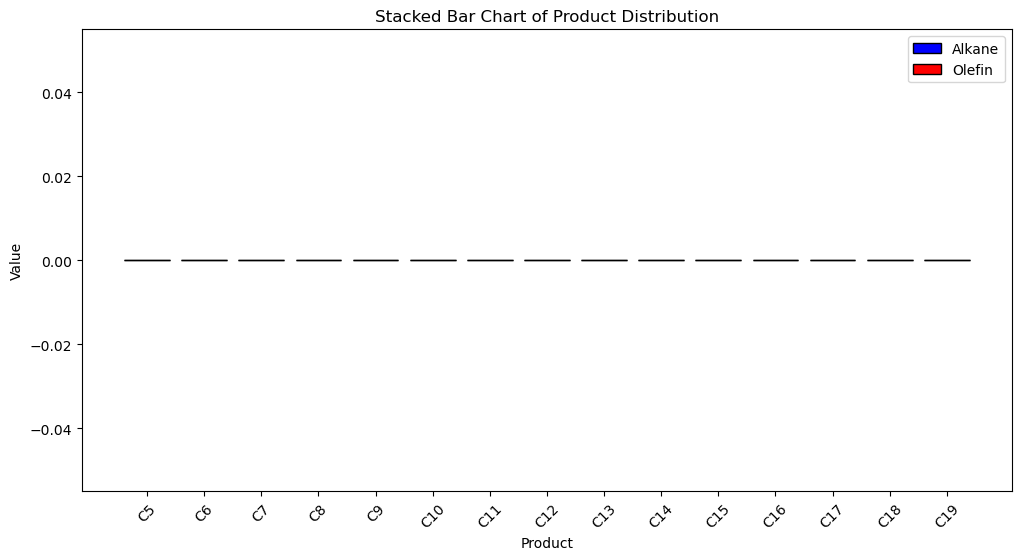

In [307]:
# diesel composition

dsl_data = summary["fuel_comp"]["PROD-DSL"]

# Separate data into two groups
groupA = [dsl_data[key] for key in dsl_data if key.endswith('A') and int(key[1:-1])>4 and int(key[1:-1])<20]
groupE = [dsl_data[key] for key in dsl_data if key.endswith('E') and int(key[1:-1])>4 and int(key[1:-1])<20]

# The position of the bars on the x-axis
r = range(len(groupA))

# Plotting the bars
plt.figure(figsize=(12, 6))
plt.bar(r, groupA, color='blue', edgecolor='black', label='Alkane')
plt.bar(r, groupE, bottom=groupA, color='red', edgecolor='black', label='Olefin')

# Add labels and title
plt.xticks(r, [key.replace('A', '') for key in dsl_data if key.endswith('A') and int(key[1:-1])>4 and int(key[1:-1])<20], rotation=45)
plt.ylabel("Value")
plt.xlabel("Product")
plt.title("Stacked Bar Chart of Product Distribution")

# Create legend & Show graphic
plt.legend()
plt.show()

In [308]:
m1.TB.pprint()

TB : Size=46, Index=k, Domain=Any, Default=None, Mutable=False
    Key   : Value
     C10A : 174.155
     C10E :   170.6
     C11A : 195.928
     C11E :  192.67
     C12A : 216.323
     C12E :   213.0
     C13A : 235.466
     C13E :  232.84
     C14A : 253.577
     C14E :   251.1
     C15A : 270.685
     C15E :  268.46
     C16A : 286.864
     C16E :  284.87
     C17A :  302.15
     C17E :  300.33
     C18A :  316.71
     C18E :  314.82
     C19A :   329.9
     C19E :  329.02
      C1A : -161.49
     C20A :  343.78
     C20E :  342.39
     C21A :   356.5
     C22A :   368.6
      C2A :   -88.6
      C2E : -103.74
      C3A :  -42.04
      C3E :   -47.7
      C4A :    -0.5
      C4E :   -6.24
      C5A :   36.07
      C5E :   30.07
      C6A :   68.73
      C6E :   63.48
      C7A :   98.43
      C7E :   93.64
      C8A :  125.68
      C8E :  121.26
      C9A :  150.82
      C9E : 146.868
       H2 : -252.76
     HDPE :   68.75
     LDPE :   68.75
       PP :   68.75
    WASTE :     nan

In [309]:
m1.sepCut.pprint()

sepCut : Size=3, Index=isep, Domain=Any, Default=None, Mutable=False
    Key  : Value
    DT1A :  -0.0
    DT2A : 126.0
    DT3A : 217.0


In [310]:
m1.eta.pprint()

eta : Size=18, Index=eta_index
    Key                      : Lower : Value : Upper : Fixed : Stale : Domain
         ('DT1A-OH', 'DT2A') :     0 :   1.0 :     1 : False : False : Binary
    ('DT1A-OH', 'PROD-ELEC') :     0 :   0.0 :     1 : False : False : Binary
     ('DT1A-OH', 'PROD-GAS') :     0 :   0.0 :     1 : False : False : Binary
     ('DT1A-OH', 'PROD-JTF') :     0 :   0.0 :     1 : False : False : Binary
         ('DT2A-OH', 'DT3A') :     0 :   0.0 :     1 : False : False : Binary
     ('DT2A-OH', 'PROD-DSL') :     0 :   0.0 :     1 : False : False : Binary
    ('DT2A-OH', 'PROD-ELEC') :     0 :   0.0 :     1 : False : False : Binary
     ('DT2A-OH', 'PROD-GAS') :     0 :   1.0 :     1 : False : False : Binary
     ('DT2A-OH', 'PROD-JTF') :     0 :   0.0 :     1 : False : False : Binary
    ('DT2A-OL', 'PROD-ELEC') :     0 :   0.0 :     1 : False : False : Binary
     ('DT2A-OL', 'PROD-GAS') :     0 :   1.0 :     1 : False : False : Binary
     ('DT2A-OL', 'PROD-JTF') :   

In [311]:
for i in m1.inlets["PROD-GAS"]:
    m1.F[i, "PROD-GAS", "C9E"].pprint()

{Member of F} : Size=2300, Index=F_index
    Key                            : Lower : Value : Upper : Fixed : Stale : Domain
    ('DT2A-OL', 'PROD-GAS', 'C9E') :     0 :   0.0 :  None : False : False : NonNegativeReals
{Member of F} : Size=2300, Index=F_index
    Key                            : Lower : Value : Upper : Fixed : Stale : Domain
    ('DT1A-OH', 'PROD-GAS', 'C9E') :     0 :   0.0 :  None : False : False : NonNegativeReals
{Member of F} : Size=2300, Index=F_index
    Key                            : Lower : Value             : Upper : Fixed : Stale : Domain
    ('DT2A-OH', 'PROD-GAS', 'C9E') :     0 : 5523.767635725411 :  None : False : False : NonNegativeReals


In [312]:
m1.FT.pprint()

FT : Size=11, Index=itech
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    DT1A :     0 :  52138.53658041642 :  None : False : False : NonNegativeReals
    DT2A :     0 :  43749.44249811406 :  None : False : False : NonNegativeReals
    DT3A :     0 :                0.0 :  None : False : False : NonNegativeReals
    FL1A :     0 :  172018.6259090812 :  None : False : False : NonNegativeReals
     R1A :     0 :                0.0 :  None : False : False : NonNegativeReals
     R1C :     0 :  61935.72927021064 :  None : False : False : NonNegativeReals
     R2A :     0 :                0.0 :  None : False : False : NonNegativeReals
     R2C :     0 :                0.0 :  None : False : False : NonNegativeReals
     R3A :     0 : 39549.429888429826 :  None : False : False : NonNegativeReals
     R3C :     0 :   95160.6768244734 :  None : False : False : NonNegativeReals
     R4C :     0 :                0.0 :  None : False : False : NonNegativeReals
